# Using Parallel Magics

IPython has a few magics for working with your engines.

This assumes you have started an IPython cluster, either with the notebook interface,
or the `ipcluster/controller/engine` commands.

In [23]:
import ipyparallel as parallel
rc = parallel.Client()
rc.block = True
dv = rc[:]
rc.ids

[0, 1, 2, 3]

Creating a Client registers the parallel magics `%px`, `%%px`, `%pxresult`, `pxconfig`, and `%autopx`.  
These magics are initially associated with a DirectView always associated with all currently registered engines.

Now we can execute code remotely with `%px`:

In [24]:
%px a=5

In [25]:
%px print(a)

[stdout:0] 5
[stdout:1] 5
[stdout:2] 5
[stdout:3] 5


In [26]:
%px a

Out[0:17]: 5

Out[1:17]: 5

Out[2:17]: 5

Out[3:17]: 5

In [27]:
with dv.sync_imports():
    import sys

importing sys on engine(s)


In [28]:
%px from __future__ import print_function
%px print("ERROR", file=sys.stderr)

[stderr:0] ERROR
[stderr:1] ERROR
[stderr:2] ERROR
[stderr:3] ERROR


You don't have to wait for results.  The `%pxconfig` magic lets you change the default blocking/targets for the `%px` magics:

In [29]:
%pxconfig --noblock

In [30]:
%px import time
%px time.sleep(5)
%px time.time()

<AsyncResult: execute>

But you will notice that this didn't output the result of the last command.
For this, we have `%pxresult`, which displays the output of the latest request:

In [13]:
%pxresult

Out[0:8]: 1488481839.667928

Out[1:8]: 1488481839.677289

Out[2:8]: 1488481839.690478

Out[3:8]: 1488481839.683551

In [31]:
%pxconfig --block

Remember, an IPython engine is IPython, so you can do magics remotely as well!

In [32]:
%%px
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

`%%px` can also be used as a cell magic, for submitting whole blocks.
This one acceps `--block` and `--noblock` flags to specify
the blocking behavior, though the default is unchanged.


In [33]:
dv.scatter('id', dv.targets, flatten=True)
dv['stride'] = len(dv)

In [34]:
%%px
print("    id=%s" % id)
print("stride=%s" % stride)

[stdout:0] 
    id=0
stride=4
[stdout:1] 
    id=1
stride=4
[stdout:2] 
    id=2
stride=4
[stdout:3] 
    id=3
stride=4


In [35]:
%%px --noblock
x = np.linspace(0,np.pi,1000)
for n in range(id, 12, stride):
    print(n)
    plt.plot(x,np.sin(n*x))
plt.title("Plot %i" % id);

<AsyncResult: execute>

[stdout:0] 
0
4
8
[stdout:1] 
1
5
9
[stdout:2] 
2
6
10
[stdout:3] 
3
7
11


[output:0]

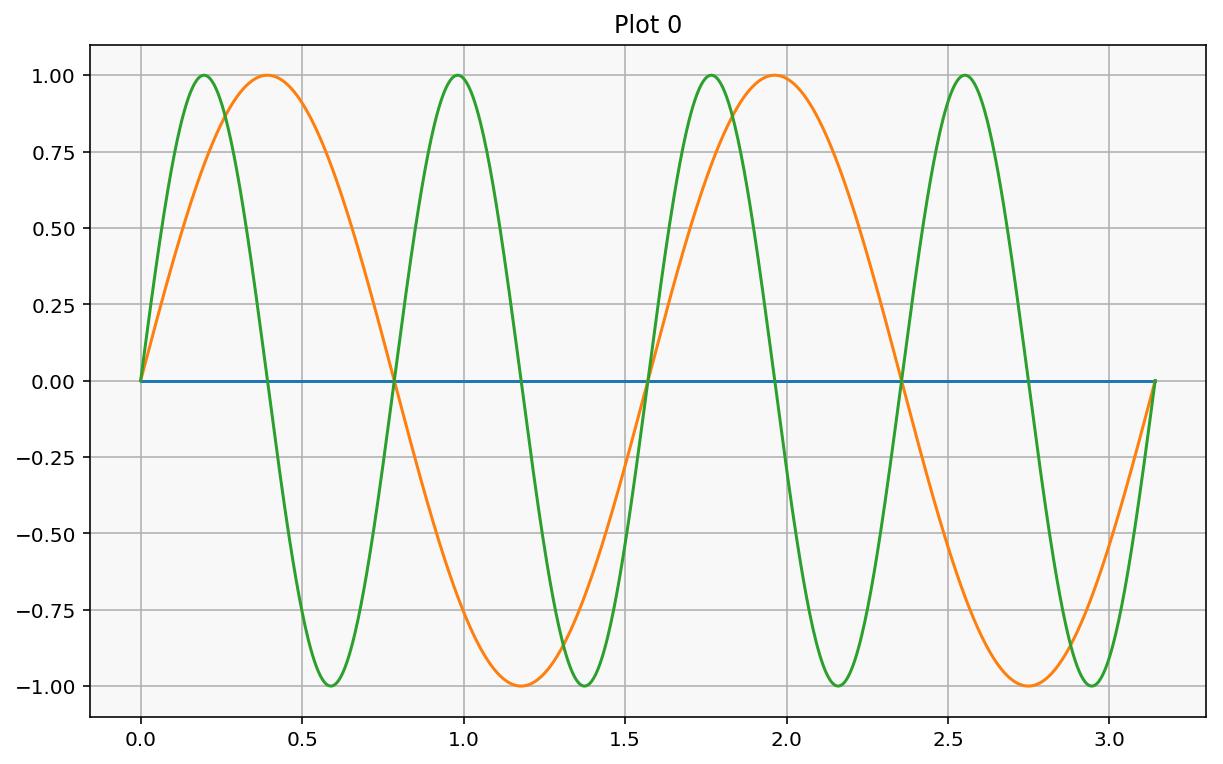

[output:1]

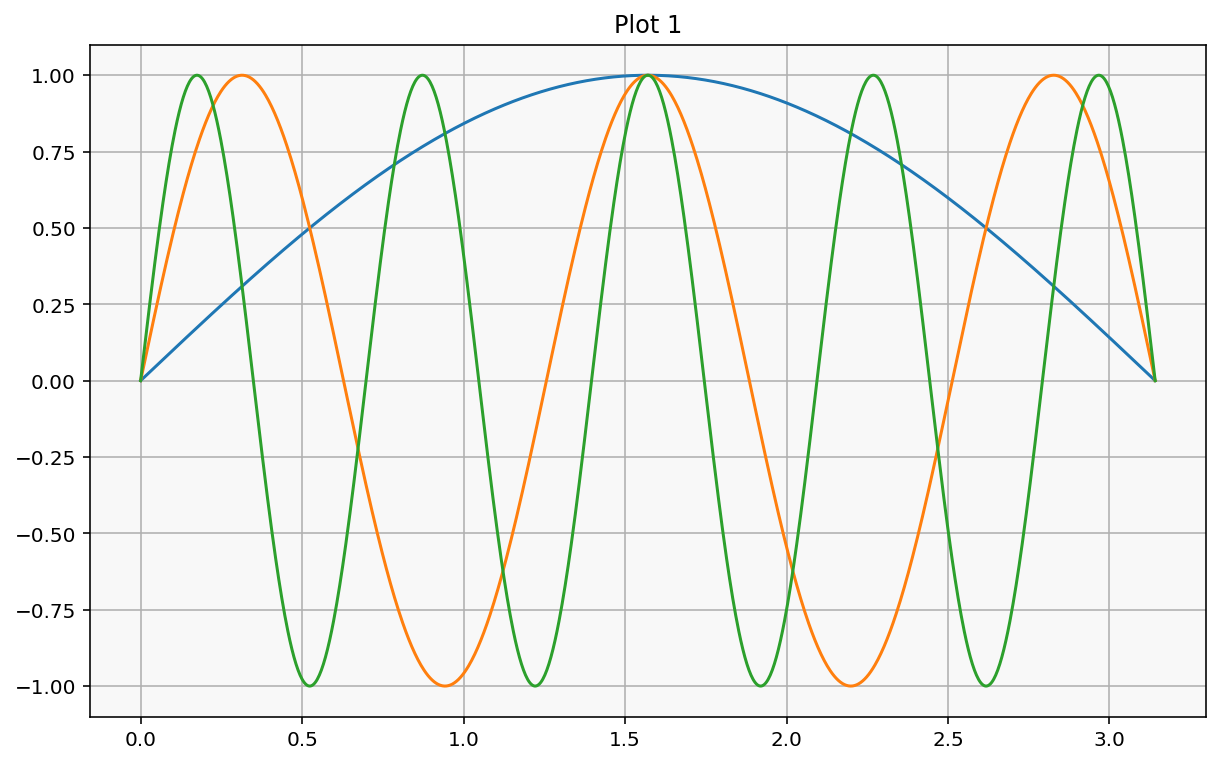

[output:2]

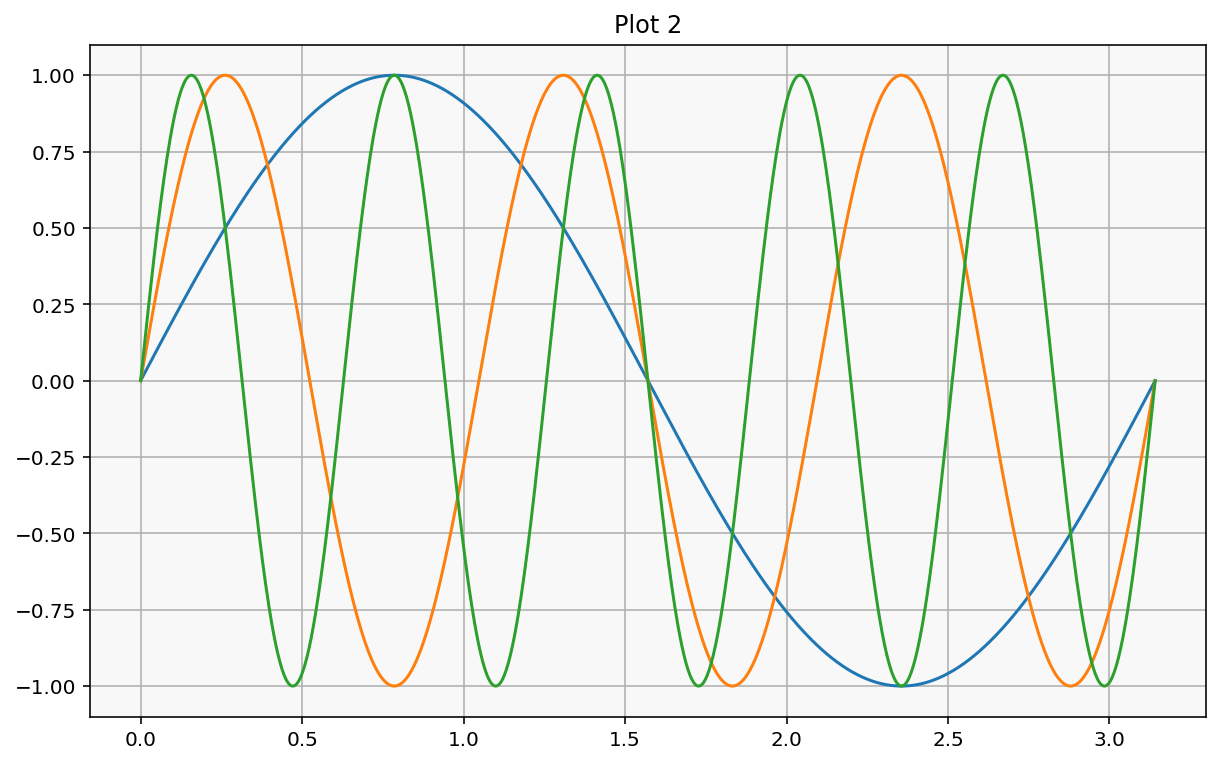

[output:3]

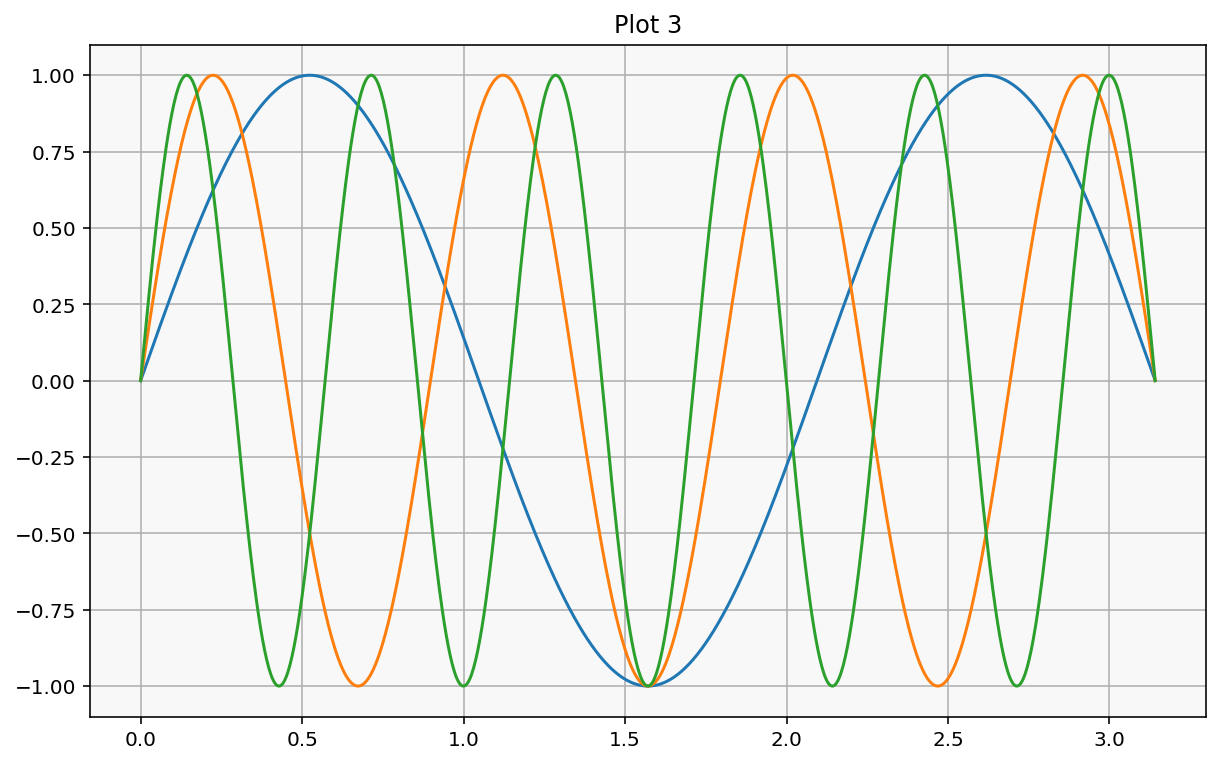

In [36]:
%pxresult

## Parallel Exceptions

When you raise exceptions with the parallel exception,
the CompositeError raised locally will display your remote traceback.

In [37]:
%%px
from numpy.random import random
A = random((100,100,'invalid shape'))

CompositeError: one or more exceptions from call to method: execute
[0:execute]: TypeError: 'str' object cannot be interpreted as an integer
[1:execute]: TypeError: 'str' object cannot be interpreted as an integer
[2:execute]: TypeError: 'str' object cannot be interpreted as an integer
[3:execute]: TypeError: 'str' object cannot be interpreted as an integer

## Remote Cell Magics

Remember, Engines are IPython too, so the cell that is run remotely by %%px can in turn use a cell magic.

In [38]:
%%px
%%bash
echo "remote parallel interactive bash!"
hostname
date
echo $$

[stdout:0] 
remote parallel interactive bash!
touchy.local
Thu Mar  2 14:12:04 EST 2017
5394
[stdout:1] 
remote parallel interactive bash!
touchy.local
Thu Mar  2 14:12:04 EST 2017
5395
[stdout:2] 
remote parallel interactive bash!
touchy.local
Thu Mar  2 14:12:04 EST 2017
5396
[stdout:3] 
remote parallel interactive bash!
touchy.local
Thu Mar  2 14:12:04 EST 2017
5397


In [39]:
%%px
%%ruby
puts 'hello from ruby'

[stdout:0] hello from ruby
[stdout:1] hello from ruby
[stdout:2] hello from ruby
[stdout:3] hello from ruby


In [40]:
dv.scatter('rank', dv.targets, flatten=True)

In [41]:
%%px
%%timeit
from numpy.random import random
from numpy.linalg import norm
N = 100 * (rank + 1)
A = random((N,N))
norm(A, 2)    

[stdout:0] 10 loops, best of 3: 25.2 ms per loop
[stdout:1] 10 loops, best of 3: 33.3 ms per loop
[stdout:2] 10 loops, best of 3: 42.7 ms per loop
[stdout:3] 10 loops, best of 3: 59.9 ms per loop


# Debugging Engines

Since the IPython engine is precisely the same object used for the notebook and qtconsole,
we can connect other fronteds directly to the engine.

The first step is to bind the engine's sockets, so its connection pattern looks like a regular kernel

In [42]:
%%px
from ipyparallel import bind_kernel
bind_kernel()

Now we can raise an exception on the engines

In [43]:
%%px

def foo(a, b):
    return a/(1-b)

def bar(b):
    return foo(2, b)

bar(1)

CompositeError: one or more exceptions from call to method: execute
[0:execute]: ZeroDivisionError: division by zero
[1:execute]: ZeroDivisionError: division by zero
[2:execute]: ZeroDivisionError: division by zero
[3:execute]: ZeroDivisionError: division by zero

Now we can connect a qtconsole to the engine(s)

In [44]:
%px %qtconsole